![Snow, trees, and mountain overlook Lake Tahoe](shap-thumbnail.jpg "")

In [2]:
from sklearn import datasets 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
import shap
import numpy as np 
import pandas as pd 

# a classic housing price dataset
# X, y = shap.datasets.california(n_points=1000)
data = datasets.fetch_california_housing(as_frame=True)
features, target = data.feature_names, data.target_names[0] 
df = data.frame 

n= 1000
x1 = np.random.normal(size=n)
x2 = np.random.normal(size=n)
x3 = np.random.normal(size=n)
y = 5 + 2*x1 -4*x2 + 1*x3 
df = pd.DataFrame(dict(x1=x1, x2=x2, x3=x3, y=y)) 
features = ['x1', 'x2', 'x3'] 
target = 'y' 


# sample data for shap computations 
X_sample = df.sample(100, random_state=0)[features]

# a simple linear model
model = LinearRegression()
# model = GradientBoostingRegressor()


model.fit(df[features], df[target]);

In [3]:
explainer = shap.Explainer(model, X_sample)
shap_values = explainer(X_sample)

In [4]:
# build an Exact explainer and explain the model predictions on the given dataset
explainer = shap.explainers.Exact(model.predict, X_sample)
shap_values = explainer(X_sample)

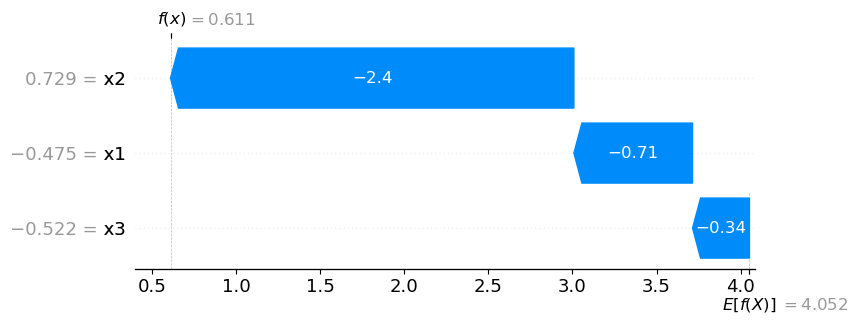

In [5]:
# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
sample_ind = 10
shap.plots.waterfall(shap_values[sample_ind]);

In [6]:
print(f'E[f(x)]= {model.predict(X_sample).mean()}')
print(f'f(x) = {model.predict(X_sample)[sample_ind]}')

E[f(x)]= 4.052488927219157
f(x) = 0.6107375016726628


In [7]:
print('Maybe the Analytical  SHAP values based on linear model coefficients')

for i, f in enumerate(features):
    sv = model.coef_[i] * (X_sample.iloc[sample_ind, i] - X_sample.iloc[:, i].mean())
    print(f'exact shap value for {f} = {sv}')

Maybe the Analytical  SHAP values based on linear model coefficients
exact shap value for x1 = -0.7054469680018287
exact shap value for x2 = -2.398168964138065
exact shap value for x3 = -0.3381354934065995


## Shapley Regression Values

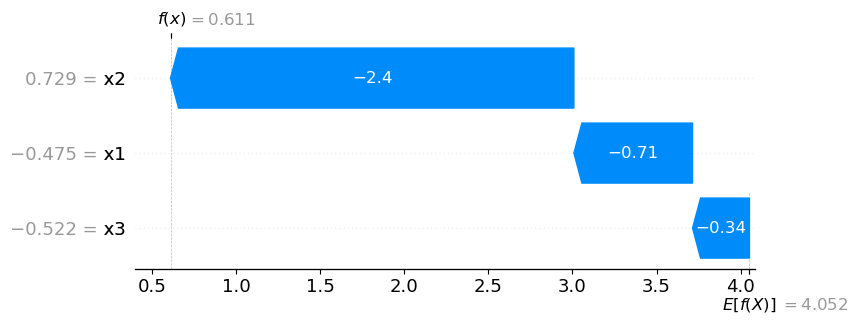

coalition = []
.   f_coalition_with_x1(x) - f_coalition(x) = -0.09442598252925016
.   scaling factor = 0.3333333333333333
.   summand = scaling factor * difference = -0.03147532750975005
coalition = ['x2']
.   f_coalition_with_x1(x) - f_coalition(x) = -0.9583006260663693
.   scaling factor = 0.16666666666666666
.   summand = scaling factor * difference = -0.15971677101106155
coalition = ['x3']
.   f_coalition_with_x1(x) - f_coalition(x) = -1.0011762617029594
.   scaling factor = 0.16666666666666666
.   summand = scaling factor * difference = -0.16686271028382654
coalition = ['x2', 'x3']
.   f_coalition_with_x1(x) - f_coalition(x) = -0.8322261110250344
.   scaling factor = 0.3333333333333333
.   summand = scaling factor * difference = -0.27740870367501147
shap value for x1 = -0.6354635124796496
coalition = []
.   f_coalition_with_x2(x) - f_coalition(x) = -1.922715183143445
.   scaling factor = 0.3333333333333333
.   summand = scaling factor * difference = -0.640905061047815
coalition = 

In [8]:
from math import factorial
from itertools import chain, combinations

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    c = chain.from_iterable(combinations(s, r) for r in range(len(s)+1))
    return list(c)

# features = ['MedInc', 'HouseAge', 'AveBedrms']

model = LinearRegression()
# model = GradientBoostingRegressor()
model.fit(df[features], df[target]);

# X_sample = df[features].sample(100, random_state=0)
# X_sample = df[features]
explainer = shap.Explainer(model, X_sample)
shap_values = explainer(X_sample)
# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
sample_ind = 10
shap.plots.waterfall(shap_values[sample_ind]);


num_features = len(features)

svs = [] 
for feature in features:
    # feature = 'MedInc' 
    # feature = 'HouseAge' 
    # feature = 'AveBedrms' 
    other_features = [f for f in features if f != feature]

    coalitions = powerset(other_features)

    summands = []
    for coalition in coalitions:
            
        coalition = list(coalition)
        num_coalition_features = len(coalition) 
        coalition_with_feature = coalition + [feature] 

        print(f'coalition = {coalition}')

        if len(coalition) > 0:
            model_without_feature = LinearRegression()
            model_without_feature.fit(df[coalition], df[target]);
            preds_without_feature = model_without_feature.predict(X_sample[coalition])
        else:
            model_mean_response = model.predict(X_sample).mean()
            preds_without_feature = model_mean_response

        model_with_feature = LinearRegression()
        model_with_feature.fit(df[coalition_with_feature], df[target]);
        preds_with_feature = model_with_feature.predict(X_sample[coalition_with_feature])

        pred_diffs = preds_with_feature - preds_without_feature
        difference = pred_diffs[sample_ind]
        scaling_factor = factorial(num_coalition_features) * factorial(num_features - num_coalition_features - 1) / factorial(num_features)
        summand = scaling_factor * difference 
        summands.append(summand)
        print(f'.   f_coalition_with_{feature}(x) - f_coalition(x) = {difference}')
        print(f'.   scaling factor = {scaling_factor}')
        print(f'.   summand = scaling factor * difference = {summand}')

    phi = np.sum(np.array(summands))
    print(f'shap value for {feature} = {phi}')
    svs.append(phi)

In [9]:
for i, f in enumerate(features): 
    print(f'shap value for {f} = {svs[i]}')

shap value for x1 = -0.6354635124796496
shap value for x2 = -2.624457963282473
shap value for x3 = -0.18182994978437012


In [10]:
sum(svs), model.predict(X_sample)[sample_ind] - model.predict(X_sample).mean()

(-3.4417514255464927, -3.441751425546494)

So the shapley regression values don't quite recover the exact shap values computed from the model coefficients, and also they don't quite match the SHAP library values either.
I think the inconsistency is that the masked model in shapley regression values is a separate model trained with a subset of features, whereas SHAP uses conditional expectations over the excluded features to compute the masked model.

## Shapley sampling values

This is from Strumbeldj et al 2014. The shap paper notes that this approach can be used to estimate the shap values.

Now it looks to me like the real contribution of the shap paper is kernel shap, which is a much faster way to approximate the shap values. 

## "Exact" shapley values with conditional expectation for reduced models

In the SHAP paper, they call a coalition of features a simplified input.
Given a feature of interest, we consider each coalition with and without that feature.
Approximate removing a feature from the model by integrating over the training set.

$$ f(h_x(z')) = E[f(z)|z_S] = E_{z_{\bar{S}}}[f(z)]$$

That's equation 9 and 11 in the SHAP paper. 

So let's find a way to compute that.
When we compute an explanation, we do it for a specific feature and instance, so choose an instance and a feature of interest.
Now copy the feature values from this instance for the coalition features and paste them over the corresponding feature values for all other instances in the dataset. Then generate predictions on this mutated training dataset. Then take the average. That's your $E_{z_{\bar{S}}}[f(z)]$ for this instance. Now do that again for the coalition with the feature of interest.


Let's start with a little story to get into the Shapley value mindset. Originally this idea comes from game theory where we have a group of players who engage in a game and receive some payoff. We then do a thought experiment to see how the payoff would change if instead of the entire group playing together, we only had specific subsets of the players.

Let's say I go to a Thai restaurant and order green curry; the menu says it comes with coconut milk, curry paste, eggplant, green beans, and tofu. Let the players be the ingredients that the cook remembered to put in the dish, and let the payoff be how satisfied I am with the dish. If the dish comes with all the ingredients I'll be very satisfied. Now suppose they forget the green beans; I'd be less satisfied, but it's not a big deal.  What about if they left out the coconut milk? At that point it's not even Thai curry anymore, and substantial dissatisfaction may arise.  What if they left out both the green beans and the coconut milk? Since the coconut milk is already missing, I wouldn't even care about the green beans at that point, so I'd be equally bummed as if they just forgot the coconut milk.
This example reveals the idea that removal of one player can affect the payoff differently depending on which other players are missing.

In [320]:
n= 1000
x1 = np.random.normal(size=n)
x2 = np.random.normal(size=n)
# x2 = x1 + np.random.normal(size=n)
x3 = np.random.normal(size=n)
y = 5 + 2*x1 -4*x2 + 1*x3 + 0.25 * np.random.normal(size=n)
df = pd.DataFrame(dict(x1=x1, x2=x2, x3=x3, y=y)) 
features = ['x1', 'x2', 'x3'] 
target = 'y' 
X = df[features].values
y = df[target].values

In [321]:
model = LinearRegression()
model.fit(X, y);

In [322]:

def generate_all_subsets(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    c = chain.from_iterable(combinations(s, r) for r in range(len(s)+1))
    return [list(t) for t in c]

In [323]:
# Eq 11 (assuming feature independence)
def conditional_expectation_of_model(model, X, coalition, idx_instance):
    X_transformed = X.copy() 
    for j in range(X.shape[1]):
        if j in coalition:
            X_transformed[:, j] = X[idx_instance, j]
    return model.predict(X_transformed).mean()


In [324]:
# # Eq 12 (assuming linearity)
# def conditional_expectation_of_model(model, X, coalition, idx_instance):
#     # X_transformed = X.copy() 
#     X_new = np.empty((1, X.shape[1]))
#     for j in range(X.shape[1]):
#         X_new[0, j] = X[idx_instance, j] if j in coalition else X[:, j].mean()
#     return model.predict(X_new)[0]

# conditional_expectation_of_model(model, X, [1, 2], 0)

In [325]:
def compute_single_shap_value(model, X, idx_instance, idx_feature):
    all_features = list(range(X.shape[1]))
    # loop over coalitions
    # set of all coalitions is based on all features except idx_feature
    all_other_features = list(set(all_features) - set([idx_feature]))
    coalitions = generate_all_subsets(all_other_features)
    terms = []
    for coalition in coalitions:    
        diff = (
            conditional_expectation_of_model(model, X, coalition + [idx_feature], idx_instance)
            - conditional_expectation_of_model(model, X, coalition, idx_instance)
        )  
        # compute the scaling factor
        num_all_features = len(all_features)
        num_coalition_features = len(coalition)
        scaling_factor = (
            factorial(num_coalition_features) 
            * factorial(num_all_features - num_coalition_features - 1) 
            / factorial(num_all_features)
        )
        term = scaling_factor * diff
        terms.append(term)
    # equation 4 from SHAP paper
    phi = sum(terms)
    return phi

In [326]:
def compute_shap_values(model, X):
    shap_values = np.empty(X.shape)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            shap_values[i, j] = compute_single_shap_value(model, X, i, j)
    return shap_values

In [327]:
compute_shap_values(model, X)

array([[-0.45543784,  2.53040933, -0.23665068],
       [ 1.76145724,  0.89655386, -0.30215803],
       [-0.09895074,  2.57944985, -0.92171331],
       ...,
       [ 1.57044424,  2.69845305,  0.9505746 ],
       [ 1.01393252,  2.53767554,  0.25762749],
       [-0.79323172,  1.59643851,  1.38760268]])

In [328]:
print('Maybe the Analytical  SHAP values based on linear model coefficients')
sample_ind = 0
for i, f in enumerate(features):
    sv = model.coef_[i] * (X[sample_ind, i] - X[:, i].mean())
    print(f'exact shap value for {f} = {sv}')

Maybe the Analytical  SHAP values based on linear model coefficients
exact shap value for x1 = -0.45543783828520173
exact shap value for x2 = 2.530409330836648
exact shap value for x3 = -0.2366506843360059


In [355]:
explainer = shap.Explainer(model, shap.maskers.Independent(X, max_samples=n), algorithm='linear')
shap_values = explainer(X)
shap_values.values

array([[-0.45543784,  2.53040933, -0.23665068],
       [ 1.76145724,  0.89655386, -0.30215803],
       [-0.09895074,  2.57944985, -0.92171331],
       ...,
       [ 1.57044424,  2.69845305,  0.9505746 ],
       [ 1.01393252,  2.53767554,  0.25762749],
       [-0.79323172,  1.59643851,  1.38760268]])

In [356]:
explainer = shap.Explainer(model, X, algorithm='linear')
shap_values = explainer(X)
shap_values.values

array([[-0.35059366,  2.21761517, -0.22349311],
       [ 1.86630141,  0.5837597 , -0.28900046],
       [ 0.00589344,  2.26665569, -0.90855573],
       ...,
       [ 1.67528842,  2.38565889,  0.96373218],
       [ 1.11877669,  2.22488138,  0.27078507],
       [-0.68838754,  1.28364435,  1.40076026]])

Good, now my from-scratch implementation matches the analytical values from linear model coefficients and the shap library.

The trick here is that the shap library uses a concept called a masker, which computes the conditional expectations for models with masked features. By default, this only integrates over 100 rows of your training dataset. Need to manually create the masker setting the max_samples parameter equal to the number of rows from training data to match my from scratch implementation.

## Tree SHAP

Let's try this for trees.

In [362]:
n= 1000
x1 = np.random.normal(size=n)
x2 = np.random.normal(size=n)
# x2 = x1 + np.random.normal(size=n)
x3 = 0 * np.random.normal(size=n)
y = 5 + 2*x1 -3*x2 + 1*x3 + 0.25 * np.random.normal(size=n)
df = pd.DataFrame(dict(x1=x1, x2=x2, x3=x3, y=y)) 
features = ['x1', 'x2', 'x3'] 
target = 'y' 
X = df[features]#.values
y = df[target].values

In [363]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(max_depth=4)
model.fit(X, y);

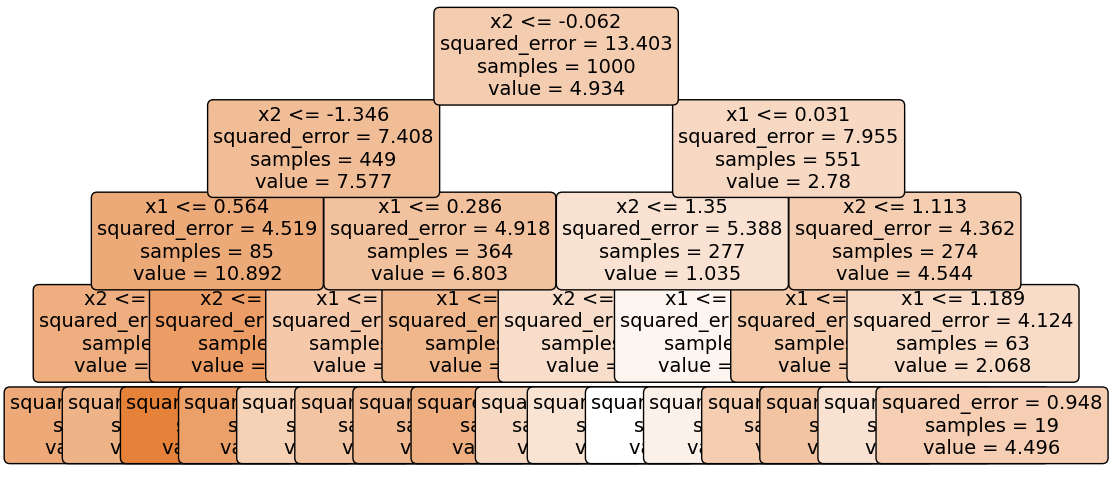

In [365]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,6))
plot_tree(model,
         feature_names=X.columns,
         filled=True,
         rounded=True,
         fontsize=14);

In [366]:
explainer = shap.Explainer(model, shap.maskers.Independent(X, max_samples=n), algorithm='tree')
shap_values = explainer(X)
shap_values.values

array([[ 1.58957631,  1.63529445,  0.        ],
       [-2.31046157,  1.44825517,  0.        ],
       [ 2.70046692, -1.28601288,  0.        ],
       ...,
       [-1.65541574, -2.5046833 ,  0.        ],
       [-0.40261557,  4.71826962,  0.        ],
       [ 3.17736359,  2.00597464,  0.        ]])

In [367]:
m1 = DecisionTreeRegressor(max_depth=4) 
m1.fit(X.values, y)
compute_shap_values(m1, X.values)

array([[ 1.58957644,  1.63529458,  0.        ],
       [-2.31046156,  1.44825528,  0.        ],
       [ 2.70046693, -1.28601294,  0.        ],
       ...,
       [-1.65541579, -2.50468331,  0.        ],
       [-0.40261566,  4.71826927,  0.        ],
       [ 3.17736381,  2.00597484,  0.        ]])

Nice, my implementation matches the library.